## $\chi^2$-GAN-Multiplayer
* kernelized version

In [1]:
from __future__ import absolute_import, division, print_function

import math
import os

import numpy as np
import prettytensor as pt
import scipy.misc
import tensorflow as tf

import scipy

from progressbar import ETA, Bar, Percentage, ProgressBar, DynamicMessage

from time import time

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.allow_soft_placement=True
sess = tf.Session(config=config)

In [2]:
flags = tf.flags
logging = tf.logging

flags.DEFINE_integer("batch_size", 128, "batch size")
flags.DEFINE_integer("updates_per_epoch", 1000, "number of updates per epoch")
flags.DEFINE_integer("max_epoch", 100, "max epoch")
flags.DEFINE_float("learning_rate", 1e-2, "learning rate")

flags.DEFINE_integer("dim", 1, "dimensionality of the target distribution")
flags.DEFINE_integer("gener_dim", 20, "dimensionality of the generator distribution")
flags.DEFINE_integer("nb_knots", 20, "dimensionality of the target distribution")
flags.DEFINE_integer("eff_dim", 10, "dimensionality of the target distribution")

FLAGS = flags.FLAGS

In [3]:
def discriminator(input_tensor):
    '''Create discriminator network.

    Args:
        input_tensor: a batch of flattened images [batch_size, 28*28]

    Returns:
        A tensor that expresses the logit of being a true sample
    '''

    return (pt.wrap(input_tensor).
            fully_connected(128).
            fully_connected(128).
            fully_connected(128).
            dropout(0.9).
            fully_connected(1, activation_fn=None)).tensor

def generator(Z=None):
    '''Create a generator network
    
    '''
    if Z==None:
        Z = tf.random_uniform([FLAGS.batch_size,FLAGS.gener_dim])
    
    return (pt.wrap(Z).
            fully_connected(128).
            fully_connected(128).
            fully_connected(128).
            fully_connected(FLAGS.dim, activation_fn=None)).tensor

def chi2_loss(Xn,Yn):
    C = tf.matmul(Xn,Yn,transpose_a=True)/(2*FLAGS.batch_size) # bias correction needed???
    chi2 = tf.reduce_sum(tf.square(C))
    return chi2

# def get_gan_loss(input_tensor,generated_tensor):
    
#     with tf.variable_scope("model-discriminator", reuse=True) as scope:
#         D_input = discriminator(input_tensor)
#     with tf.variable_scope("model-discriminator", reuse=True) as scope:
#         D_generated = discriminator(generated_tensor)
        
#     return tf.reduce_mean(D_input-tf.nn.softplus(D_input)-tf.nn.softplus(D_generated))

In [4]:
mtn_weights = [.3,.7]
mu = np.array([-1,1.5])
sig = np.array([.5,.5])


def mg_sampler(n,mtn_weights,mu,sig):
    mtn_samples = np.random.multinomial(1,mtn_weights,(n))
    sampl_idx = np.argmax(mtn_samples,1)
    mg_samples = np.reshape(mu[sampl_idx],[n,1])+np.reshape(sig[sampl_idx],[n,1])*np.random.randn(n,1)
    return mg_samples

In [5]:
def pdist2(a,b,na,nb,dim):
    
    a = tf.reshape(a,[-1,dim])
    b = tf.reshape(b,[-1,dim])
    
    aa = tf.tile(tf.reshape(tf.reduce_sum(tf.square(a),[1]),[-1,1]),[1,nb])
    bb = tf.transpose(tf.tile(tf.reshape(tf.reduce_sum(tf.square(b),[1]),[-1,1]),[1,na]))
    ab = tf.matmul(a,tf.transpose(b))

    D = tf.sqrt(tf.nn.relu(aa+bb-2*ab))
    
    return D

def np_rbf_dot(a,b,sig,na,nb,dim):
    # Fast Gaussian kernel evaluation (numpy)
    # a,b: n x d
    
    a = np.reshape(a,[-1,dim])
    b = np.reshape(b,[-1,dim])
    
    aa = np.tile(np.reshape(np.sum(a**2,axis=1),[-1,1]),[1,nb])
    bb = np.tile(np.reshape(np.sum(b**2,axis=1),[-1,1]),[1,na]).T
    ab = np.dot(a,b.T)

    D = aa+bb-2*ab

    K = np.exp(-D/(2*sig**2))
    
    return K

def tf_rbf_dot(a,b,sig,na,nb,dim):
    
    a = tf.reshape(a,[-1,dim])
    b = tf.reshape(b,[-1,dim])
    
    aa = tf.tile(tf.reshape(tf.reduce_sum(tf.square(a),[1]),[-1,1]),[1,nb])
    bb = tf.transpose(tf.tile(tf.reshape(tf.reduce_sum(tf.square(b),[1]),[-1,1]),[1,na]))
    ab = tf.matmul(a,b,transpose_b=True)

    D = aa+bb-2*ab

    K = tf.exp(-D/(2*sig**2))
    
    return K

In [6]:
knots = np.linspace(-4,4,FLAGS.nb_knots)
bw = 1.

input_tensor = tf.placeholder(tf.float32, [FLAGS.batch_size, FLAGS.dim])
learning_rate = tf.placeholder(tf.float32)
# input_code = tf.placeholder(tf.float32, [FLAGS.batch_size, FLAGS.hidden_size])

T_orth = tf.placeholder(tf.float32, [FLAGS.nb_knots, FLAGS.eff_dim]) # Normalizing to orthogonal basis
# S_orth = tf.placeholder(tf.float32, [1, FLAGS.eff_dim]) # Normalizing to unit variance
T_optc = tf.placeholder(tf.float32, [FLAGS.eff_dim, 1]) # optimal contrast

ema = tf.train.ExponentialMovingAverage(decay=0.99)

label = tf.constant(np.concatenate((np.ones([FLAGS.batch_size,1]),\
                    -np.ones([FLAGS.batch_size,1]))),dtype=tf.float32)

tf_knots = tf.constant(np.reshape(knots,[FLAGS.nb_knots,1]),dtype=tf.float32)

with tf.device('/cpu:0'):

    with pt.defaults_scope(activation_fn=tf.nn.elu,
                           batch_normalize=True,
                           learned_moments_update_rate=0.0003,
                           variance_epsilon=0.001,
                           scale_after_normalization=True):
        with pt.defaults_scope(phase=pt.Phase.train):
            with tf.variable_scope("generator") as scope:
                generated_tensor = generator()

        with pt.defaults_scope(phase=pt.Phase.test):
            with tf.variable_scope("generator", reuse=True) as scope:
                generated_tensor_test = generator()
                
    X = tf.concat((input_tensor,generated_tensor),axis=0)
                
    F = tf_rbf_dot(X,tf_knots,sig=bw,na=2*FLAGS.batch_size,nb=FLAGS.nb_knots,dim=FLAGS.dim)
                
    F_mean,_ = tf.nn.moments(F,axes=[0])   
    
    averages_op_F_mean = ema.apply([F_mean])
    
    F_demean = F - ema.average(F_mean)
#     F_demean = F - F_mean
    
    F_cov = tf.matmul(F_demean,F_demean,transpose_a=True)/(2*FLAGS.batch_size)
    
    Fn = tf.matmul(F_demean,T_orth)
    
    F_optc = tf.matmul(Fn,T_optc)
    
    gener_loss = chi2_loss(F_optc,label)
    
    CCO = tf.matmul(Fn,label,transpose_a=True)/(2*FLAGS.batch_size)
    
    averages_op_F_cov_CCO = ema.apply([F_cov, CCO])
    maintain_averages_op = tf.group(averages_op_F_mean,averages_op_F_cov_CCO)
    
    gener_vars = [v for v in tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES) if v.name.startswith('generator')]

    optimizer = tf.train.AdamOptimizer(learning_rate, epsilon=1.0)
    
    train_gan_gener = pt.apply_optimizer(optimizer, losses=[gener_loss], var_list=gener_vars)

In [7]:
# Initialization

init = tf.global_variables_initializer()
sess.run(init)

In [8]:
# Burn-in

BURN_IN = 20

x = mg_sampler(FLAGS.batch_size,mtn_weights,mu,sig)

F_mean_val = sess.run(F_mean,{input_tensor: x})
op_F_mean = tf.assign(ema.average(F_mean),F_mean_val)
_ = sess.run(op_F_mean)

F_cov_val = sess.run(F_cov,{input_tensor: x})
op_F_cov = tf.assign(ema.average(F_cov),F_cov_val)
_ = sess.run(op_F_cov)

Cxx = F_cov_val
Ux,Sx,Vx = np.linalg.svd(Cxx)
Ux = Ux[:,:FLAGS.eff_dim]/np.reshape(np.sqrt(Sx[:FLAGS.eff_dim]),[1,FLAGS.eff_dim])

CCO_val = sess.run(CCO,{input_tensor: x, T_orth: Ux})
op_CCO = tf.assign(ema.average(CCO),CCO_val)
_ = sess.run(op_CCO)

for step in range(BURN_IN):
    
    x = mg_sampler(FLAGS.batch_size,mtn_weights,mu,sig)
    
    _ = sess.run(maintain_averages_op,{input_tensor: x, T_orth: Ux})
    
    Cxx,Cxy = sess.run([ema.average(F_cov),ema.average(CCO)])

    Ux,Sx,Vx = np.linalg.svd(Cxx)
    Ux = Ux[:,:FLAGS.eff_dim]/np.reshape(np.sqrt(Sx[:FLAGS.eff_dim]),[1,FLAGS.eff_dim])

Uxy,Sxy,Vxy = np.linalg.svd(Cxy,full_matrices=False)

[1, 0.086115620175842192, 5.182267904281616]
[2, 0.086830274063220719, 5.163246154785156]
[3, 0.086184089404530817, 5.206221103668213]
[4, 0.085968971931375565, 5.128520965576172]
[5, 0.087889218465425079, 5.178215026855469]
[6, 0.086192818166688084, 5.080262899398804]
[7, 0.086048407345544545, 5.147589921951294]
[8, 0.085858639787882565, 5.067448139190674]
[9, 0.084785007070749999, 5.139621019363403]
[10, 0.084423114889767017, 5.180535078048706]
[11, 0.08132712031062693, 5.1484949588775635]
[12, 0.081373805548064407, 5.114130020141602]
[13, 0.079682173098903145, 5.197898864746094]
[14, 0.078674408837221557, 5.126786947250366]
[15, 0.076647935433313247, 5.121380090713501]
[16, 0.076549671204760666, 5.185914993286133]
[17, 0.076705684563145041, 5.1614649295806885]
[18, 0.075862815384287394, 5.10950493812561]
[19, 0.074133423135150228, 5.08572793006897]
[20, 0.075782057137228548, 5.186225175857544]
[21, 0.076658733482938266, 5.113922834396362]
[22, 0.073766319744754588, 5.143254995346069

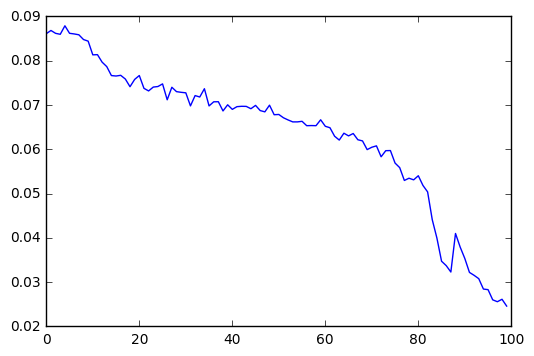

In [13]:
# Training

lr = 1e-3

max_epoch = 100
updates_per_epoch = 1000
# max_epoch = 20
# updates_per_epoch = 100
# max_epoch = 100
# updates_per_epoch = 1

epoch_record = np.zeros([max_epoch,])

for epoch_id in range(max_epoch):
    
    loss_record = np.zeros([updates_per_epoch,])
    
    t0 = time()
    
    for step in range(updates_per_epoch):

        x = mg_sampler(FLAGS.batch_size,mtn_weights,mu,sig)
        
        _,loss_val,_,Cxx,Cxy = sess.run([train_gan_gener,gener_loss,
                    maintain_averages_op,ema.average(F_cov),ema.average(CCO)], 
                    {input_tensor: x, T_orth: Ux, T_optc: Uxy, learning_rate: lr})
        
        Ux,Sx,Vx = np.linalg.svd(Cxx)
        Ux = Ux[:,:FLAGS.eff_dim]/np.reshape(np.sqrt(Sx[:FLAGS.eff_dim]),[1,FLAGS.eff_dim])
        
        Uxy,Sxy,Vxy = np.linalg.svd(Cxy,full_matrices=False)
        
        loss_record[step] = loss_val
        
    t1 = time()
        
    print([epoch_id+1,np.mean(loss_record),t1-t0])
    epoch_record[epoch_id] = np.mean(loss_record)

_ = plt.plot(epoch_record)

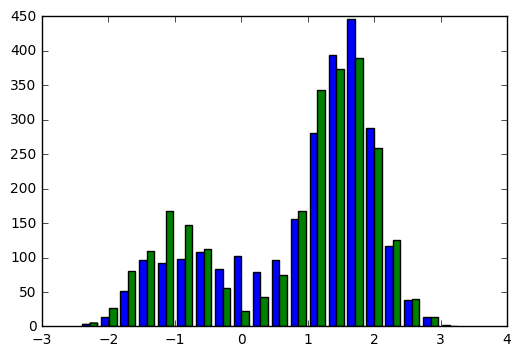

In [14]:
MLOOP = 20

gener_samples = np.zeros([MLOOP*FLAGS.batch_size,])
# real_samples = np.random.randn(MLOOP*FLAGS.batch_size,)
real_samples = mg_sampler(MLOOP*FLAGS.batch_size,mtn_weights,mu,sig)
real_samples = np.reshape(real_samples,[MLOOP*FLAGS.batch_size,])
for mloop in range(MLOOP):
    
    y = sess.run(generated_tensor)
    
    gener_samples[mloop*FLAGS.batch_size:(mloop+1)*FLAGS.batch_size] = np.reshape(y,[FLAGS.batch_size,])
    
_,_,_ = plt.hist((gener_samples,real_samples),bins=20)